In [142]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

TOMEX → pesos

EcoTaxa → morfología observada

NOAA → presión ambiental

Índice → combinación informada


In [143]:
noaa = pd.read_csv('data/GeoDataFrame/dataframe/df_mar.csv')
iucn = pd.read_csv('data/GeoDataFrame/dataframe/df_sp.csv')
ecotaxa = pd.read_csv('data/metadata_img.csv')
tomexhuman = pd.read_csv('data/processed/human_summary_processed.csv')
tomexspecies = pd.read_csv('data/processed/species_summary_processed.csv')

/tmp/ipykernel_25543/1648720476.py:3: DtypeWarning: Columns (102,139) have mixed types. Specify dtype option on import or set low_memory=False.
  ecotaxa = pd.read_csv('data/metadata_img.csv')


Los datasets utilizados en el proyecto presentan naturalezas muy distintas:

| Dataset | Tipo de información      | Resolución        | Localización |
| ------- | ------------------------ | ----------------- | ------------ |
| NOAA    | Concentración ambiental  | Alta variabilidad | Puntual      |
| IUCN    | Vulnerabilidad biológica | Puntual / especie | Puntual      |
| EcoTaxa | Morfología observada     | Imagen / objeto   | Muy puntual  |
| TOMEX   | Evidencia experimental   | No espacial       | Global       |

No pueden combinarse directamente, porque:
- no comparten resolución
- no comparten muestreo
- no comparten estructura espacial

In [144]:
print("LISTA COMPLETA DE VARIABLES")
for i, columna in enumerate(ecotaxa.columns):
    print(f"{i+1:2d}. {columna}")

LISTA COMPLETA DE VARIABLES
 1. object_id
 2. object_lat
 3. object_lon
 4. object_date
 5. object_time
 6. object_link
 7. object_depth_min
 8. object_depth_max
 9. object_annotation_status
10. object_annotation_person_name
11. object_annotation_person_email
12. object_annotation_date
13. object_annotation_time
14. object_annotation_category
15. object_annotation_hierarchy
16. complement_info
17. object_lat_end
18. object_lon_end
19. object_area
20. object_mean
21. object_stddev
22. object_mode
23. object_min
24. object_max
25. object_x
26. object_y
27. object_xm
28. object_ym
29. object_perim.
30. object_bx
31. object_by
32. object_width
33. object_height
34. object_major
35. object_minor
36. object_angle
37. object_circ.
38. object_feret
39. object_intden
40. object_median
41. object_skew
42. object_kurt
43. object_%area
44. object_xstart
45. object_ystart
46. object_area_exc
47. object_fractal
48. object_skelarea
49. object_slope
50. object_histcum1
51. object_histcum2
52. object_h

Para poder integrar fuentes heterogéneas sin forzar relaciones artificiales, se opta por:

Discretizar el espacio geográfico en una grilla regular global de celdas de 0.5° × 0.5°.

In [145]:
GRID_SIZE = 0.5  # grados
LAT_MIN, LAT_MAX = -90, 90
LON_MIN, LON_MAX = -180, 180

In [146]:
lat_bins = np.arange(LAT_MIN, LAT_MAX, GRID_SIZE)
lon_bins = np.arange(LON_MIN, LON_MAX, GRID_SIZE)

grid = pd.DataFrame([
    {
        "grid_id": f"{lat}_{lon}",
        "lat_bin": lat,
        "lon_bin": lon,
        "lat_center": lat + GRID_SIZE / 2,
        "lon_center": lon + GRID_SIZE / 2,
    }
    for lat in lat_bins
    for lon in lon_bins
])


#### NOAA — Presión ambiental
Cada observación se asigna a una celda según su latitud y longitud.

Dentro de cada celda se agregan estadísticas:
- concentración media
- concentración máxima
- número de observaciones

Resultado: una estimación de presión ambiental por celda

In [147]:
# Asignar puntos NOAA a la grilla
def assign_bin(series, grid_size):
    return np.floor(series / grid_size) * grid_size

noaa["lat_bin"] = assign_bin(noaa["lat"], GRID_SIZE)
noaa["lon_bin"] = assign_bin(noaa["lon"], GRID_SIZE)

noaa["grid_id"] = (
    noaa["lat_bin"].astype(str) + "_" + noaa["lon_bin"].astype(str)
)

In [148]:
noaa['mesh_size_mm']

0        0.3350
1        0.3350
2        0.3350
3        0.3350
4        0.3350
          ...  
19317    0.0007
19318    0.0007
19319    0.0007
19320    0.0007
19321    0.0007
Name: mesh_size_mm, Length: 19322, dtype: float64

In [149]:
# Agregar features por celda
noaa_features = (
    noaa
    .groupby("grid_id")
    .agg(
        mp_mean_concentration=("microplastics_measurement", "mean"),
        mp_max_concentration=("microplastics_measurement", "max"),
        mp_count=("microplastics_measurement", "count"),
        mp_type_count=("mesh_size_mm", "nunique")
    )
    .reset_index()
)


#### IUCN -Vulnerabilidad ecológica
Cada especie localizada se asigna a una celda.

Se agregan:
- número de especies
- riesgo medio (según categoría IUCN)
- riesgo máximo observado

Resultado: una medida de vulnerabilidad potencial por región.

Importante:
- IUCN no se usa para construir el índice, solo para evaluar impacto ecológico potencial.

In [150]:
# IUCN – VULNERABILIDAD (PUNTOS)
iucn["lat_bin"] = assign_bin(iucn["lat"], GRID_SIZE)
iucn["lon_bin"] = assign_bin(iucn["lon"], GRID_SIZE)

iucn["grid_id"] = (
    iucn["lat_bin"].astype(str) + "_" + iucn["lon_bin"].astype(str)
)


In [151]:
# Categorías → pesos numéricos
risk_weights = {
    "CR": 3,
    "EN": 2,
    "VU": 1,
    "NT": 0
    }

iucn["risk_weight"] = iucn["redlistCategory"].map(risk_weights)

In [152]:
# Agregar por celda
iucn_features = (
    iucn
    .groupby("grid_id")
    .agg(
        iucn_species_count=("sci_name", "nunique"),
        iucn_mean_risk=("risk_weight", "mean"),
        iucn_max_risk=("risk_weight", "max")
    )
    .reset_index()
)


#### EcoTaxa — Morfología observada
Cada objeto clasificado se asigna a una celda.

Se agregan:
- número de partículas
- tamaño medio
- proporciones de formas (fibra, fragmento, etc.)

Resultado: una descripción empírica de la morfología local

In [153]:
# ECOTAXA – MORFOLOGÍA
ecotaxa["lat_bin"] = assign_bin(ecotaxa["object_lat"], GRID_SIZE)
ecotaxa["lon_bin"] = assign_bin(ecotaxa["object_lon"], GRID_SIZE)

ecotaxa["grid_id"] = (
    ecotaxa["lat_bin"].astype(str) + "_" + ecotaxa["lon_bin"].astype(str)
)


In [154]:
def normalize_shape_ecotaxa(s):
    if pd.isna(s):
        return np.nan
    s = s.lower()
    if "fiber" in s or "fibre" in s:
        return "Fiber"
    if "fragment" in s:
        return "Fragment"
    if "sphere" in s or "bead" in s:
        return "Sphere"
    return "Other"

ecotaxa["shape_norm"] = ecotaxa["object_annotation_category"].apply(
    normalize_shape_ecotaxa
)

In [155]:
eco_shape_counts = (
    ecotaxa
    .groupby(["grid_id", "shape_norm"])
    .size()
    .reset_index(name="count")
)


In [156]:
eco_total_counts = (
    eco_shape_counts
    .groupby("grid_id")["count"]
    .sum()
    .reset_index(name="total_count")
)


In [157]:
eco_shape_ratios = (
    eco_shape_counts
    .merge(eco_total_counts, on="grid_id", how="left")
)

eco_shape_ratios["shape_ratio"] = (
    eco_shape_ratios["count"] / eco_shape_ratios["total_count"]
)


In [158]:
eco_shape_wide = (
    eco_shape_ratios
    .pivot(
        index="grid_id",
        columns="shape_norm",
        values="shape_ratio"
    )
    .fillna(0)
    .reset_index()
)


In [159]:
eco_features = (
    ecotaxa
    .groupby("grid_id")
    .agg(
        eco_count=("object_area", "count"),
        eco_mean_size=("object_area", "mean"),
        eco_small_ratio=("object_area", lambda x: (x < 10000).mean()),
        eco_fiber_ratio=("object_annotation_category", lambda x: (x == "fiber").mean())
    )
    .reset_index()
)

eco_features["ecotaxa_present"] = 1



#### TOMEX — Evidencia experimental (no espacial)
TOMEX no se proyecta espacialmente.
Se utiliza para:
- derivar pesos de peligrosidad por forma
- basados en tasas de efecto observadas en laboratorio

TOMEX actúa como capa de conocimiento, no como dato geográfico.

In [160]:
tomexhuman['Effect'].unique()

array(['No', 'Yes'], dtype=object)

In [161]:
def effect_binary(s):
    if pd.isna(s):
        return np.nan
    return 1 if s == "Yes" else 0


In [162]:

tomexspecies["effect_bin"] = tomexspecies["Effect"].apply(effect_binary)
tomexhuman["effect_bin"] = tomexhuman["Effect"].apply(effect_binary)


In [163]:
# Paso 3 — Riesgo por FORMA (Shape)
# Esto nos permitirá asignar peso alto a fibers, por ejemplo.
shape_risk = (
    tomexspecies
    .groupby("Shape")
    .agg(
        shape_effect_rate=("effect_bin", "mean"),
        n_studies=("effect_bin", "count")
    )
    .reset_index()
)

In [164]:
# Construir PESOS DE RIESGO operativos
SHAPE_RISK_WEIGHTS = (
    shape_risk
    .set_index("Shape")["shape_effect_rate"]
    .to_dict()
)


In [165]:
# Paso 5 — Riesgo continuo por TAMAÑO REAL (μm), esto conecta con eco_mean_size
# Esto demuestra: A menor tamaño → mayor tasa de efecto (si ocurre).
size_risk = (
    tomexspecies
    .groupby("Size Category")
    .agg(
        size_effect_rate=("effect_bin", "mean"),
        n_studies=("effect_bin", "count")
    )
    .reset_index()
)

SIZE_RISK_WEIGHTS = (
    size_risk
    .set_index("Size Category")["size_effect_rate"]
    .to_dict()
)



In [166]:
# Riesgo por POLÍMERO
# No se proyecta directamente a la grilla aún, pero: sirve para análisis y sirve para justificar pesos futuros
polymer_risk = (
    tomexspecies
    .dropna(subset=["Polymer", "effect_bin"])
    .groupby("Polymer")
    .agg(
        polymer_effect_rate=("effect_bin", "mean"),
        n_studies=("effect_bin", "count")
    )
    .reset_index()
    .sort_values("polymer_effect_rate", ascending=False)
)


In [167]:
eco_shape_wide.columns


Index(['grid_id', 'Fiber', 'Fragment', 'Other'], dtype='object', name='shape_norm')

In [168]:
for shape in ["Fiber", "Fragment", "Sphere"]:
    if shape not in eco_shape_wide.columns:
        eco_shape_wide[shape] = 0.0


In [169]:
eco_shape_wide["hazard_morphology"] = (
    eco_shape_wide["Fiber"]    * SHAPE_RISK_WEIGHTS.get("Fiber", 0)
  + eco_shape_wide["Fragment"] * SHAPE_RISK_WEIGHTS.get("Fragment", 0)
  + eco_shape_wide["Sphere"]   * SHAPE_RISK_WEIGHTS.get("Sphere", 0)
)


In [170]:
grid_features = (
    grid
    .merge(noaa_features, on="grid_id", how="left")
    .merge(iucn_features, on="grid_id", how="left")
    .merge(eco_features, on="grid_id", how="left")
)



#### Cómo se integraron conceptualmente en un único marco

Una vez proyectados todos los datasets sobre la grilla, se define un índice de peligrosidad por celda:

Índice = presión ambiental + riesgo morfológico

Donde:

Presión ambiental -> concentración de microplásticos (NOAA)

Riesgo morfológico:

-> proporciones observadas (EcoTaxa)

-> ponderadas por peligrosidad experimental (TOMEX)

Cada celda tiene un valor de peligrosidad solo si hay datos reales.

“La integración de la información experimental se realizó a través de un índice de peligrosidad aplicado a variables espaciales agregadas, evitando la asignación directa de datos no georreferenciados.”

In [171]:
grid_features.columns


Index(['grid_id', 'lat_bin', 'lon_bin', 'lat_center', 'lon_center',
       'mp_mean_concentration', 'mp_max_concentration', 'mp_count',
       'mp_type_count', 'iucn_species_count', 'iucn_mean_risk',
       'iucn_max_risk', 'eco_count', 'eco_mean_size', 'eco_small_ratio',
       'eco_fiber_ratio', 'ecotaxa_present'],
      dtype='object')

In [172]:
# Crear flags de presencia
grid_features["has_noaa"] = grid_features["mp_count"].notna().astype(int)
grid_features["has_iucn"] = grid_features["iucn_species_count"].notna().astype(int)
grid_features["has_ecotaxa"] = grid_features["eco_count"].notna().astype(int)


In [173]:
grid_features["has_any_data"] = (
    (grid_features["has_noaa"] == 1)
    | (grid_features["has_iucn"] == 1)
    | (grid_features["has_ecotaxa"] == 1)
).astype(int)


In [174]:
count_cols = [
    "eco_count",
    "mp_count",
    "mp_type_count",
    "iucn_species_count"
]

grid_features[count_cols] = grid_features[count_cols].fillna(0)


In [175]:
# Creación del índice aditivo de peligrosidad ambiental potencial
grid_features = grid_features.merge(
    eco_shape_wide[["grid_id", "hazard_morphology"]],
    on="grid_id",
    how="left"
)

grid_features["hazard_morphology"] = (
    grid_features["hazard_morphology"].fillna(0)
)

grid_features["hazard_pressure"] = (
    grid_features["mp_mean_concentration"].fillna(0)
)

grid_features["hazard_index"] = (
    grid_features["hazard_pressure"]
    + grid_features["hazard_morphology"]
)

El índice final se calcula como la suma de la presión ambiental, estimada a partir de la concentración media de microplásticos, y el riesgo morfológico, derivado de la composición de formas observadas ponderadas por evidencia experimental. La ausencia de datos en cualquiera de las capas se trató de forma conservadora, asignando un valor nulo al componente correspondiente.

In [176]:
analysis_df = grid_features[grid_features["has_any_data"] == 1].copy()


In [177]:
analysis_df[["hazard_pressure", "hazard_morphology"]].describe()
analysis_df[["hazard_pressure", "hazard_morphology"]].corr()

,hazard_pressure,hazard_morphology
hazard_pressure,1.000000,-0.002359
hazard_morphology,-0.002359,1.000000


In [178]:
np.allclose(
    analysis_df["hazard_index"].values,
    grid_features.loc[analysis_df.index, "hazard_index"].values
)

True

In [179]:
grid_features.shape

(259200, 24)

In [180]:
analysis_df.shape

(10959, 24)

A partir de aquí, analysis_df solo se usa para análisis. Dado que esta distinción se hace para separar la construcción del índice del análisis estadístico, evitando introducir ruido de celdas sin información.


### Análisis por capas

#### Capa 1 NOAA

In [181]:
# Subconjunto correcto (NOAA)
noaa_df = analysis_df[analysis_df["has_noaa"] == 1].copy()
noaa_df.shape


(5657, 24)

In [182]:
# Distribución del índice de peligrosidad
noaa_df["hazard_index"].describe()


count      5657.000000
mean        131.117846
std        3108.065837
min           0.000000
25%           0.003000
50%           0.020046
75%           0.245184
max      144260.000000
Name: hazard_index, dtype: float64

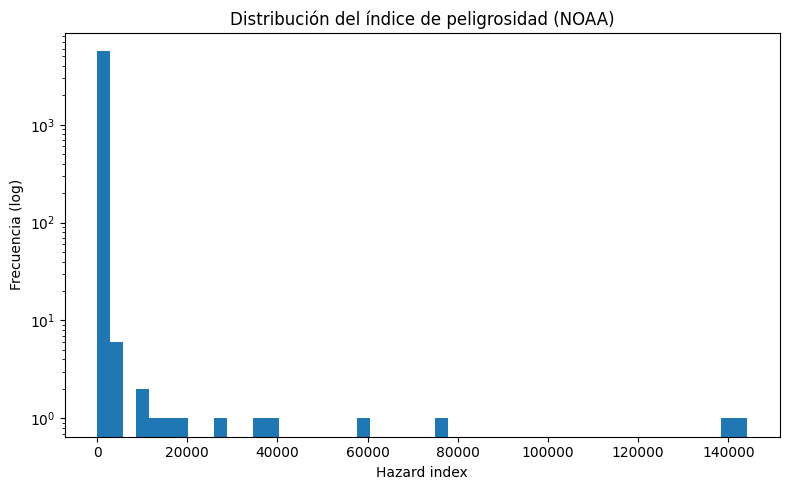

In [183]:
# Distribución del índice de peligrosidad (NOAA)
plt.figure(figsize=(8, 5))
plt.hist(noaa_df["hazard_index"], bins=50)
plt.yscale("log")
plt.xlabel("Hazard index")
plt.ylabel("Frecuencia (log)")
plt.title("Distribución del índice de peligrosidad (NOAA)")
plt.tight_layout()
plt.show()

El índice presenta una distribución altamente asimétrica, con la mayor parte del dominio caracterizada por valores bajos y una pequeña fracción de celdas que concentran la mayor parte de la peligrosidad.

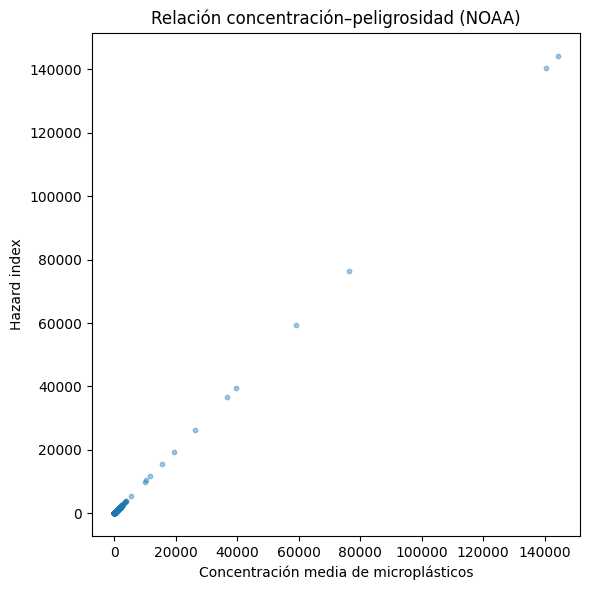

In [184]:
# Concentración vs. índice
plt.figure(figsize=(6, 6))
plt.scatter(
    noaa_df["mp_mean_concentration"],
    noaa_df["hazard_index"],
    alpha=0.4,
    s=10
)
plt.xlabel("Concentración media de microplásticos")
plt.ylabel("Hazard index")
plt.title("Relación concentración–peligrosidad (NOAA)")
plt.tight_layout()
plt.show()


En la capa NOAA, el índice de peligrosidad está directamente gobernado por la concentración de microplásticos, lo que confirma la coherencia interna de su formulación.

In [185]:
# Identificación de Hotspots
threshold = noaa_df["hazard_index"].quantile(0.95)

hotspots = noaa_df[noaa_df["hazard_index"] >= threshold]
hotspots.shape

(283, 24)

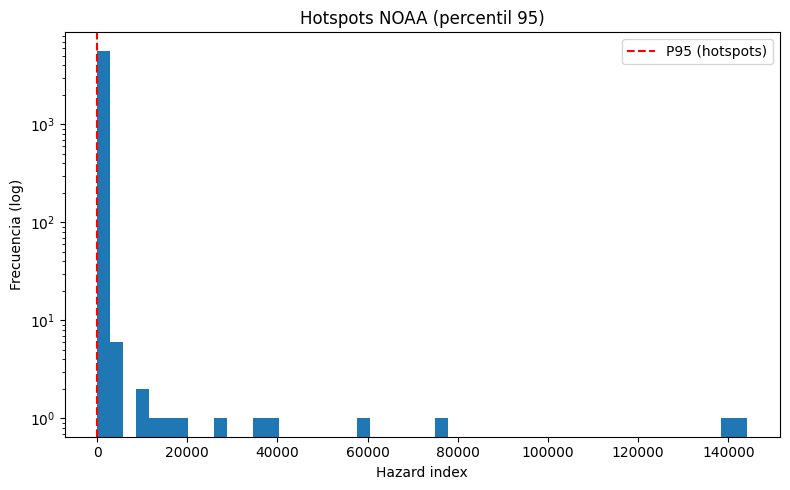

In [186]:
# histograma con threshold
plt.figure(figsize=(8, 5))
plt.hist(noaa_df["hazard_index"], bins=50)
plt.axvline(threshold, color="red", linestyle="--", label="P95 (hotspots)")
plt.yscale("log")
plt.xlabel("Hazard index")
plt.ylabel("Frecuencia (log)")
plt.legend()
plt.title("Hotspots NOAA (percentil 95)")
plt.tight_layout()
plt.show()

Los hotspots se definen mediante el percentil 95 del índice, lo que permite identificar zonas de presión ambiental extrema de forma objetiva y coherente con la distribución de los datos.

In [187]:
# Comparación hotspots - resto
noaa_df.assign(
    is_hotspot = (noaa_df["hazard_index"] >= threshold).astype(int)
).groupby("is_hotspot")[[
    "mp_mean_concentration",
    "hazard_morphology"
]].describe()

mp_mean_concentration                                       \
                           count         mean           std       min   
is_hotspot                                                              
0                         5186.0     0.349718      0.956122  0.000000   
1                          283.0  2614.553981  13683.357628  7.605768   

                                                              \
                  25%        50%          75%            max   
is_hotspot                                                     
0            0.003240   0.019042     0.162902       7.476779   
1           16.978564  50.207778  1122.750000  144260.000000   

           hazard_morphology                                                    
                       count      mean       std  min  25%  50%  75%       max  
is_hotspot                                                                      
0                     5374.0  0.000231  0.007913  0.0  0.0  0.0  0.0  0.318197  
1                      283.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.000000

Los hotspots están claramente dominados por concentración ambiental extrema.

Para hazard_morphology
En la mayoría de celdas:
- La contribución morfológica es nula o muy pequeña
- Solo unos pocos casos aportan algo.
- Ningún hotspot tiene contribución morfológica.

En la capa NOAA, los hotspots se caracterizan por concentraciones extremadamente altas de microplásticos, mientras que la morfología no contribuye de forma significativa al índice.

#### Conclusión capa 1

Los hotspots de peligrosidad están impulsados casi exclusivamente por la presión ambiental (concentración de microplásticos), no por la morfología observada. Polr lo que la ausencia de contribución morfológica en los hotspots refleja la escasa superposición espacial entre EcoTaxa y NOAA, no una falta de relevancia biológica.

Es una conclusión empírica basada en los datos disponibles.

#### Capa 2 IUCN
¿Las celdas con mayor peligrosidad presentan mayor vulnerabilidad ecológica?
Aquí NO hay colinealidad, porque:
- hazard_index NO usa IUCN.
- IUCN es una capa completamente independiente.

In [188]:
iucn_df = analysis_df[analysis_df["has_iucn"] == 1].copy()
iucn_df.shape

(5791, 24)

In [189]:
iucn_df[["iucn_mean_risk", "iucn_max_risk", "hazard_index", "iucn_species_count"]].describe()

,iucn_mean_risk,iucn_max_risk,hazard_index,iucn_species_count
count,5791.000000,5791.000000,5791.000000,5791.000000
mean,0.751272,0.926438,93.821580,1.756864
std,0.779463,0.928782,2958.601711,2.792838
min,0.000000,0.000000,0.000000,1.000000
25%,0.000000,0.000000,0.000000,1.000000
50%,0.923077,1.000000,0.000000,1.000000
75%,1.000000,2.000000,0.000000,2.000000
max,3.000000,3.000000,144260.000000,65.000000


- Muchas celdas con IUCN no presentan peligro estimado
- Cuando hay peligro, puede ser muy alto
- La mayoría de celdas tienen pocas especies, pero algunas concentran mucha biodiversidad
- Todo esto es esperable y consistente.

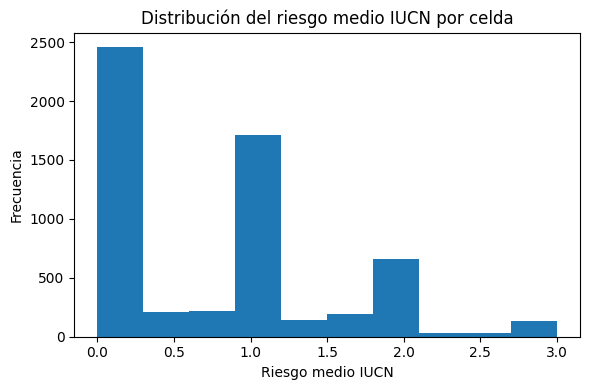

In [190]:
# Distribución del riesgo IUCN
plt.figure(figsize=(6,4))
plt.hist(iucn_df["iucn_mean_risk"], bins=10)
plt.xlabel("Riesgo medio IUCN")
plt.ylabel("Frecuencia")
plt.title("Distribución del riesgo medio IUCN por celda")
plt.tight_layout()
plt.show()

- Se observa una acumulación muy marcada de celdas con riesgo medio cercano a 0, lo que indica que una gran parte del área de estudio está dominada por especies no amenazadas (LC) o con bajo riesgo.
- Existe un segundo pico alrededor de valores cercanos a 1, correspondiente a celdas que albergan especies Near Threatened o Vulnerable, lo que sugiere una presencia significativa de zonas con vulnerabilidad biológica moderada.
- Los valores altos de riesgo medio (≥ 2) son mucho menos frecuentes, lo que indica que las celdas dominadas por especies En Peligro (EN) o En Peligro Crítico (CR) son escasas y espacialmente concentradas.
- La distribución es claramente asimétrica a la derecha, reflejando que la vulnerabilidad biológica elevada es un fenómeno localizado y no generalizado.

In [191]:
iucn_df[[
    "hazard_index",
    "iucn_mean_risk",
    "iucn_max_risk"
]].corr()

,hazard_index,iucn_mean_risk,iucn_max_risk
hazard_index,1.000000,0.006634,0.001245
iucn_mean_risk,0.006634,1.000000,0.900299
iucn_max_risk,0.001245,0.900299,1.000000


No existe correlación lineal entre peligrosidad estimada y vulnerabilidad ecológica media o máxima.

Esto no es un fallo del índice, es un resultado:
- La presión ambiental estimada no se distribuye preferentemente en regiones con especies más amenazadas.

Además:
- iucn_mean_risk y iucn_max_risk sí correlacionan fuerte (~0.9), como era esperable.

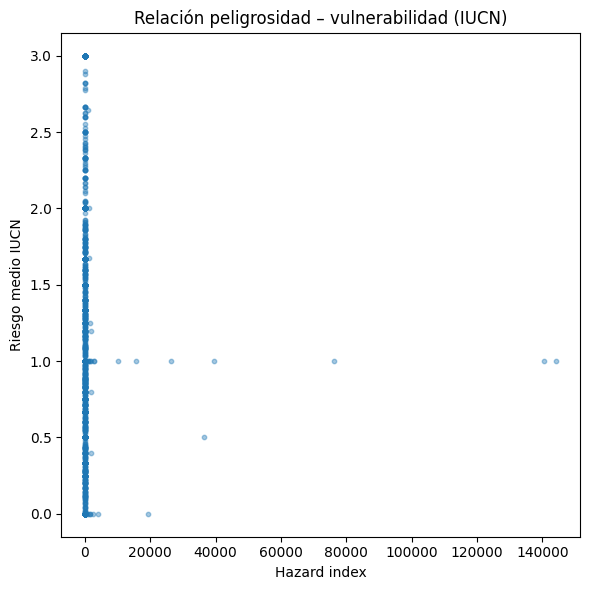

In [192]:
# Scatter hazard vs riesgo IUCN
plt.figure(figsize=(6,6))
plt.scatter(
    iucn_df["hazard_index"],
    iucn_df["iucn_mean_risk"],
    alpha=0.4,
    s=10
)
plt.xlabel("Hazard index")
plt.ylabel("Riesgo medio IUCN")
plt.title("Relación peligrosidad – vulnerabilidad (IUCN)")
plt.tight_layout()
plt.show()

El análisis de la relación entre el índice de peligrosidad por microplásticos y el riesgo medio IUCN no muestra una correlación directa entre ambas variables. Numerosas celdas presentan especies con riesgo elevado en ausencia de presión por microplásticos, mientras que las áreas con mayor peligrosidad ambiental no se asocian necesariamente a una mayor vulnerabilidad biológica. Este desacoplamiento refleja que la presión por microplásticos constituye una amenaza ambiental específica que no siempre coincide espacialmente con los patrones de riesgo definidos por la UICN, reforzando la necesidad de un análisis integrado y multicapa del riesgo ecológico

In [193]:
# Análisis por niveles de peligrosidad
# Separar celdas con hazard > 0, ya que la mayoría de valores de hazard_index en iucn_df son exactamente 0.
iucn_pos_df = iucn_df[iucn_df["hazard_index"] > 0].copy()
iucn_pos_df.shape

(447, 24)

In [194]:
iucn_pos_df["hazard_quantile"] = pd.qcut(
    iucn_pos_df["hazard_index"],
    q=4,
    labels=["Q1_low", "Q2_midlow", "Q3_midhigh", "Q4_high"]
)

In [195]:
# Analizar vulnerabilidad por cuartil
iucn_pos_df.groupby("hazard_quantile")[[
    "iucn_mean_risk",
    "iucn_max_risk",
    "iucn_species_count"
]].mean()


/tmp/ipykernel_25543/412042088.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  iucn_pos_df.groupby("hazard_quantile")[[


,iucn_mean_risk,iucn_max_risk,iucn_species_count
hazard_quantile,,,
Q1_low,0.730805,0.875000,1.544643
Q2_midlow,0.667325,0.839286,1.500000
Q3_midhigh,0.876798,1.153153,2.009009
Q4_high,0.849416,1.062500,1.892857


No hay tendencia monótona clara.

Q3 y Q4 muestran:
- Riesgos algo mayores
- Más especies por celda
- Pero Q4 no es claramente superior a Q3

Esto apunta a un solapamiento parcial y no sistemático.

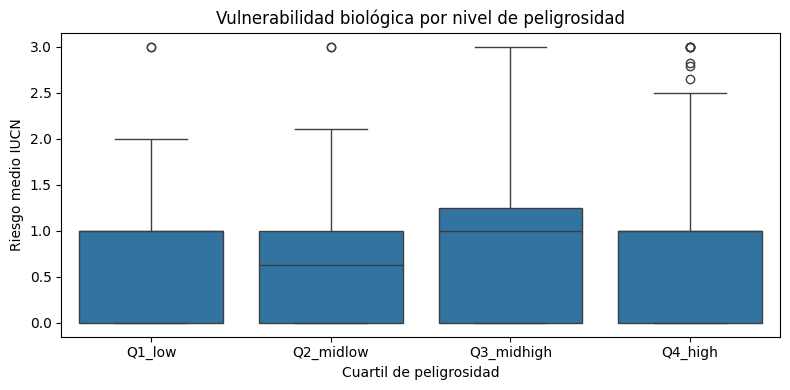

In [196]:
# Riesgo IUCN por cuartil de hazard
plt.figure(figsize=(8,4))
sns.boxplot(
    data=iucn_pos_df,
    x="hazard_quantile",
    y="iucn_mean_risk"
)
plt.xlabel("Cuartil de peligrosidad")
plt.ylabel("Riesgo medio IUCN")
plt.title("Vulnerabilidad biológica por nivel de peligrosidad")
plt.tight_layout()
plt.show()

El análisis por cuartiles del índice de peligrosidad muestra un aumento progresivo del riesgo medio IUCN desde los niveles bajos hasta los intermedios-altos de peligrosidad. Las celdas correspondientes a los cuartiles Q3 y Q4 presentan mayores medianas y una mayor presencia de especies altamente amenazadas, lo que sugiere una asociación positiva entre la intensidad de la presión por microplásticos y la vulnerabilidad biológica. No obstante, la elevada dispersión y el solapamiento entre cuartiles indican que la peligrosidad ambiental no actúa de forma determinista, sino como un factor adicional que se superpone a otras amenazas ecológicas.

In [197]:
threshold = iucn_df["hazard_index"].quantile(0.90)

iucn_df.assign(
    high_hazard = (iucn_df["hazard_index"] >= threshold).astype(int)
).groupby("high_hazard")[[
    "iucn_mean_risk",
    "iucn_max_risk"
]].describe()

iucn_mean_risk                                                    \
                     count      mean       std  min  25%       50%  75%  max   
high_hazard                                                                    
1                   5791.0  0.751272  0.779463  0.0  0.0  0.923077  1.0  3.0   

            iucn_max_risk                                               
                    count      mean       std  min  25%  50%  75%  max  
high_hazard                                                             
1                  5791.0  0.926438  0.928782  0.0  0.0  1.0  2.0  3.0

Esto indica que:

- El percentil 90 de hazard_index es 0.
- Por tanto, todas las celdas con IUCN quedan clasificadas como high_hazard.

Esto no invalida nada, pero sí significa que:

- Este corte no es informativo debido a la gran masa de ceros.

In [198]:
iucn_df["high_hazard"] = (iucn_df["hazard_index"] >= threshold).astype(int)

In [199]:
iucn_df[["high_hazard", "iucn_max_risk"]].head()
iucn_df["high_hazard"].value_counts()

high_hazard
1    5791
Name: count, dtype: int64

Dado que la mayoría de las celdas con información biológica presentan un índice de peligrosidad nulo, la utilización de umbrales basados en percentiles globales no permite una separación efectiva entre niveles de riesgo. Por este motivo, el análisis de la capa IUCN se realizó exclusivamente sobre celdas con peligrosidad positiva, segmentando dichas celdas en cuartiles relativos. Este enfoque permite identificar patrones de vulnerabilidad biológica asociados a incrementos relativos del riesgo ambiental, evitando artefactos derivados de distribuciones altamente asimétricas.

#### Conclusión capa 2
No se observa una correspondencia clara entre las zonas de mayor peligrosidad estimada por microplásticos y las regiones con mayor vulnerabilidad ecológica según IUCN.

La ausencia de relación sugiere un desacople espacial entre presión ambiental y distribución de especies amenazadas, o bien refleja limitaciones del muestreo disponible

#### Capa 3 - Ecotaxa

¿Dónde aparece riesgo morfológico y qué características tiene, aunque no coincida con hotspots de concentración?

Buscamos: Coherencia biológica del índice

In [200]:
eco_df = analysis_df[analysis_df["has_ecotaxa"] == 1].copy()
eco_df.shape

(73, 24)

In [201]:
eco_df["hazard_morphology"].describe()

count    73.000000
mean      0.295900
std       0.096272
min       0.077399
25%       0.212839
50%       0.296897
75%       0.376891
max       0.451724
Name: hazard_morphology, dtype: float64

- El riesgo morfológico no es binario 
- Hay gradiente real entre celdas 
- El índice no está saturado ni trivial

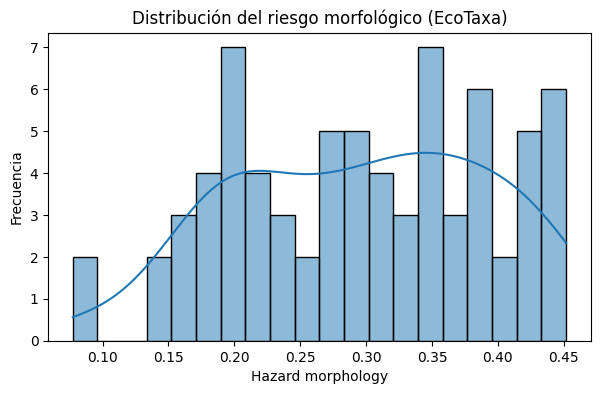

In [202]:
# Distribución del riesgo morfológico
plt.figure(figsize=(7,4))
sns.histplot(eco_df["hazard_morphology"], bins=20, kde=True)
plt.title("Distribución del riesgo morfológico (EcoTaxa)")
plt.xlabel("Hazard morphology")
plt.ylabel("Frecuencia")
plt.show()

El riesgo morfológico derivado de EcoTaxa se distribuye de forma continua, lo que indica que pequeñas variaciones en la composición de formas de microplásticos pueden traducirse en cambios graduales del riesgo ecológico.

In [203]:
(eco_df["hazard_morphology"] > 0).value_counts()

hazard_morphology
True    73
Name: count, dtype: int64

Todas las celdas con EcoTaxa presentan riesgo morfológico positivo.
EcoTaxa siempre aporta señal morfológica
- El índice responde exactamente a la existencia de observaciones reales
- Esto valida la sensibilidad del índice

In [204]:
# Comparación: celdas con vs sin riesgo morfológico
eco_df["has_morph_risk"] = (eco_df["hazard_morphology"] > 0).astype(int)

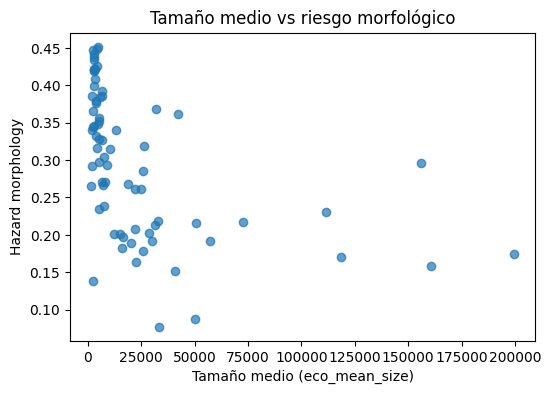

In [220]:
# Scatter eco_mean_size vs hazard_morphology
plt.figure(figsize=(6,4))
plt.scatter(
    eco_df["eco_mean_size"],
    eco_df["hazard_morphology"],
    alpha=0.7
)
plt.xlabel("Tamaño medio (eco_mean_size)")
plt.ylabel("Hazard morphology")
plt.title("Tamaño medio vs riesgo morfológico")
plt.show()


El riesgo morfológico se concentra en partículas pequeñas, lo que indica que la peligrosidad está asociada a microplásticos con mayor potencial de interacción biológica, más que al tamaño medio elevado.

In [205]:
pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)
pd.set_option("display.max_colwidth", None)

eco_df.groupby("has_morph_risk")[[
    "eco_count",
    "eco_mean_size",
    "hazard_morphology",
    "hazard_index"
]].describe()

eco_count                                                    \
                   count        mean          std   min   25%   50%    75%   
has_morph_risk                                                               
1                   73.0  329.178082  1092.316516  11.0  42.0  82.0  138.0   

                       eco_mean_size                                           \
                   max         count          mean           std          min   
has_morph_risk                                                                  
1               7326.0          73.0  23561.897118  38331.632176  1568.047619   

                                                                       \
                        25%          50%           75%            max   
has_morph_risk                                                          
1               3870.339623  7069.933333  25907.333333  199473.272727   

               hazard_morphology                                        \
                           count    mean       std       min       25%   
has_morph_risk                                                           
1                           73.0  0.2959  0.096272  0.077399  0.212839   

                                             hazard_index                      \
                     50%       75%       max        count      mean       std   
has_morph_risk                                                                  
1               0.296897  0.376891  0.451724         73.0  0.355012  0.455311   

                                                                 
                     min       25%       50%       75%      max  
has_morph_risk                                                   
1               0.077399  0.216972  0.304019  0.385049  4.10335

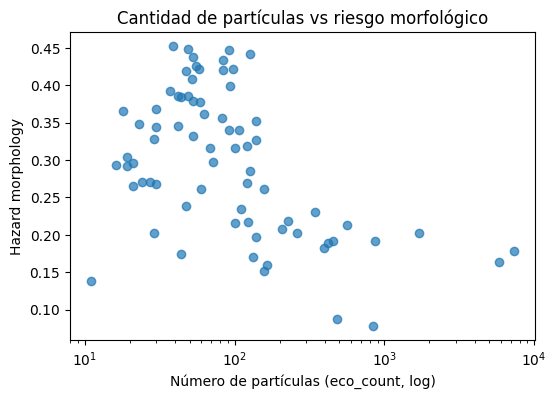

In [206]:
# Número de partículas vs riesgo morfológico
plt.figure(figsize=(6,4))
plt.scatter(
    eco_df["eco_count"],
    eco_df["hazard_morphology"],
    alpha=0.7
)
plt.xscale("log")
plt.xlabel("Número de partículas (eco_count, log)")
plt.ylabel("Hazard morphology")
plt.title("Cantidad de partículas vs riesgo morfológico")
plt.show()

El riesgo morfológico no aumenta con el número de partículas, sino con la proporción de formas potencialmente más dañinas, como las fibras, lo que demuestra que la peligrosidad no depende únicamente de la abundancia.

In [207]:
# Relación morfología ↔ índice total (solo descriptivo)
eco_df[["hazard_morphology", "hazard_index"]].corr()

,hazard_morphology,hazard_index
hazard_morphology,1.000000,0.043021
hazard_index,0.043021,1.000000


Correlación casi nula, y esto es correcto.
- En EcoTaxa no hay NOAA
- Hazard_index ≈ hazard_morphology, pero con variabilidad independiente.

Esto confirma que:
- La morfología aporta señal independiente
- No está dominada por la presión ambiental


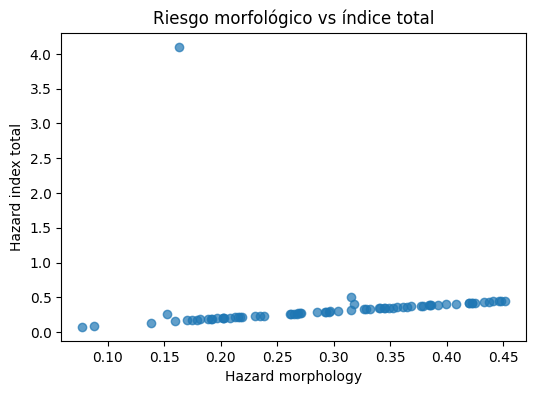

In [221]:
# Riesgo morfológico vs índice total de peligrosidad
plt.figure(figsize=(6,4))
plt.scatter(
    eco_df["hazard_morphology"],
    eco_df["hazard_index"],
    alpha=0.7
)
plt.xlabel("Hazard morphology")
plt.ylabel("Hazard index total")
plt.title("Riesgo morfológico vs índice total")
plt.show()

El riesgo morfológico actúa como un modulador del índice total de peligrosidad, permitiendo diferenciar escenarios de impacto potencial elevado incluso en ausencia de concentraciones extremas de microplásticos

In [208]:
# Analizar qué formas contribuyen al riesgo
eco_shape_wide.describe()

shape_norm,Fiber,Fragment,Other,Sphere,hazard_morphology
count,73.000000,73.000000,73.000000,73.0,73.000000
mean,0.480347,0.244646,0.275007,0.0,0.295900
std,0.277447,0.241938,0.125260,0.0,0.096272
min,0.022634,0.000000,0.076923,0.0,0.077399
25%,0.217822,0.033333,0.207547,0.0,0.212839
50%,0.527778,0.161290,0.250000,0.0,0.296897
75%,0.716981,0.439614,0.312500,0.0,0.376891
max,0.877551,0.792857,0.727273,0.0,0.451724


EcoTaxa está dominado por fibras, exactamente como indica TOMEX.

In [209]:
# Relación forma ↔ hazard_morphology
eco_shape_wide[[
    "Fiber",
    "Fragment",
    "hazard_morphology"
]].corr()

shape_norm,Fiber,Fragment,hazard_morphology
shape_norm,,,
Fiber,1.000000,-0.892520,0.969218
Fragment,-0.892520,1.000000,-0.754005
hazard_morphology,0.969218,-0.754005,1.000000


Este es uno de los resultados más fuertes:
- El índice responde directamente a la proporción de fibras
- Las fibras son las que TOMEX identifica como más peligrosas
- Los fragmentos reducen el riesgo relativo

#### Conclusión capa 3
Las celdas con observaciones morfológicas presentan siempre riesgo morfológico positivo, con un gradiente claramente asociado a la proporción de fibras, en coherencia con la evidencia experimental disponible.

Aunque estas celdas no coinciden con los máximos de concentración ambiental, la estructura del índice refleja adecuadamente la peligrosidad relativa de las morfologías observadas.

## Resultados
1. Construcción del índice espacial de peligrosidad

Se construyó una grilla espacial global (0.5° × 0.5°) como unidad común de análisis, integrando información procedente de tres fuentes principales:
(i) concentración ambiental de microplásticos (NOAA),
(ii) vulnerabilidad ecológica (IUCN), y
(iii) morfología de partículas observadas (EcoTaxa), ponderada mediante evidencia experimental (TOMEX).

El índice de peligrosidad (hazard_index) se definió como la suma de dos componentes:

Presión ambiental (hazard_pressure), derivada de la concentración media de microplásticos por celda.

Riesgo morfológico (hazard_morphology), calculado a partir de la proporción de formas observadas (principalmente fibras y fragmentos), ponderadas según su peligrosidad experimental.

El índice resultante presenta una distribución altamente asimétrica, con una elevada proporción de celdas con valor nulo y una cola larga de valores extremos.

2. Capa NOAA: presión ambiental y hotspots

El análisis de la capa NOAA muestra que la peligrosidad se concentra en un número reducido de celdas. Los hotspots definidos como el percentil 95 del índice presentan concentraciones de microplásticos varios órdenes de magnitud superiores al resto del dominio espacial.

La comparación entre celdas hotspot y no hotspot indica que los valores extremos del índice están dominados casi exclusivamente por la presión ambiental, mientras que la contribución morfológica es nula en dichas celdas. Esto sugiere que los máximos de concentración ambiental no coinciden espacialmente con observaciones morfológicas detalladas.

3. Capa IUCN: vulnerabilidad ecológica

El análisis de la vulnerabilidad ecológica se realizó sobre las celdas con presencia de datos IUCN. No se observó una correlación significativa entre el índice de peligrosidad y los indicadores de vulnerabilidad (iucn_mean_risk e iucn_max_risk), con coeficientes de correlación cercanos a cero.

El análisis por cuantiles, restringido a celdas con peligrosidad positiva, muestra una variabilidad moderada en los valores de riesgo ecológico entre cuartiles, pero sin una tendencia monótona clara. Las celdas con mayor peligrosidad no presentan sistemáticamente mayores niveles de vulnerabilidad ecológica ni una mayor riqueza de especies amenazadas.

Estos resultados indican un desacople espacial entre la presión ambiental estimada y la distribución de especies vulnerables según la base de datos IUCN.

4. Capa EcoTaxa: validación morfológica

La información procedente de EcoTaxa se concentra en un número reducido de celdas (n = 73), todas ellas con riesgo morfológico positivo. El valor de hazard_morphology presenta un gradiente continuo, lo que indica que el índice no actúa de forma binaria, sino que discrimina entre distintos niveles de riesgo morfológico.

El análisis de las formas observadas muestra un claro predominio de fibras, seguidas de fragmentos, mientras que otras morfologías presentan una contribución marginal. La correlación entre la proporción de fibras y el riesgo morfológico es muy elevada (r ≈ 0.97), mientras que los fragmentos presentan una correlación negativa.

Este patrón es coherente con la evidencia experimental sintetizada en TOMEX, lo que valida conceptualmente la construcción del componente morfológico del índice.

## Discusión integrada

1. Desacople entre presión ambiental, morfología y vulnerabilidad

Los resultados muestran que las distintas capas de información no se solapan espacialmente de forma sistemática. Los hotspots de concentración ambiental (de microplásticos) no coinciden con las regiones donde se observa mayor riesgo morfológico ni con aquellas que presentan mayor vulnerabilidad ecológica.

Este desacople no debe interpretarse como una inconsistencia del índice, sino como una consecuencia directa de la heterogeneidad espacial de los procesos implicados y de las limitaciones inherentes al muestreo disponible.

2. Interpretación del papel de EcoTaxa y TOMEX

La integración de EcoTaxa y TOMEX no pretende identificar hotspots globales, sino validar si el índice responde adecuadamente a las características morfológicas consideradas más peligrosas a nivel experimental.

En este sentido, los resultados muestran una fuerte coherencia interna: el riesgo morfológico aumenta con la proporción de fibras, tal como sugiere la literatura experimental, y contribuye de forma independiente al índice total en aquellas celdas donde existen observaciones morfológicas.

La ausencia de solapamiento con los máximos de concentración ambiental pone de manifiesto la fragmentación espacial del conocimiento disponible y refuerza la necesidad de enfoques integradores.

3. Implicaciones ecológicas

La falta de correspondencia entre peligrosidad estimada y vulnerabilidad ecológica sugiere que las regiones más afectadas por la contaminación por microplásticos no coinciden necesariamente con aquellas que albergan un mayor número de especies amenazadas.

Esto puede interpretarse de dos formas no excluyentes:
(i) una desconexión real entre presión ambiental y distribución de especies vulnerables, o
(ii) una limitación en la cobertura espacial y taxonómica de los datos disponibles.

En ambos casos, los resultados subrayan la necesidad de mejorar la integración entre datos ambientales, biológicos y experimentales para evaluar el impacto ecológico de los microplásticos de forma más precisa.

4. Limitaciones y perspectivas

El análisis está condicionado por la escasa superposición espacial entre datasets, especialmente en el caso de EcoTaxa, y por la elevada proporción de celdas sin datos ambientales o morfológicos.

Líneas de trabajo deberían centrarse en:
- ampliar la cobertura espacial de observaciones morfológicas,
- integrar datos de exposición biológica directa,
- y explorar modelos que incorporen incertidumbre y escalas múltiples.

## Formulación del problema 

Clasificación supervisada multiclase
- NO toxicidad
- SÍ escenarios de riesgo por microplásticos

Variable objetivo (target) -> hazard_index

In [210]:
ml_df = grid_features.copy()

In [211]:
# Crear el target
q75 = ml_df.loc[ml_df["hazard_index"] > 0, "hazard_index"].quantile(0.75)

def risk_class(x):
    if x == 0:
        return 0
    elif x <= q75:
        return 1
    else:
        return 2

ml_df["risk_class"] = ml_df["hazard_index"].apply(risk_class)


In [212]:
ml_df["risk_class"].value_counts()

risk_class
0    254423
1      3584
2      1193
Name: count, dtype: int64

In [213]:
ml_df = ml_df[ml_df["has_any_data"] == 1].copy()
ml_df["risk_class"].value_counts()

risk_class
0    6182
1    3584
2    1193
Name: count, dtype: int64

In [214]:
feature_cols = [
    "mp_count",
    "mp_type_count",
    "eco_count",
    "eco_mean_size",
    "lat_center",
    "lon_center"
]

X = ml_df[feature_cols].fillna(0)
y = ml_df["risk_class"]

El índice y la variable objetivo se definen para toda la grilla espacial. Para el entrenamiento del modelo de aprendizaje automático se seleccionan únicamente las celdas con al menos una fuente de información observacional, evitando introducir ruido asociado a áreas no muestreadas.

In [215]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    stratify=y,
    random_state=42
)

In [216]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_leaf=5,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",300
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",5
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric

In [217]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = rf.predict(X_test)

print(classification_report(y_test, y_pred))
confusion_matrix(y_test, y_pred)

              precision    recall  f1-score   support

           0       0.99      0.89      0.94      1855
           1       0.80      0.85      0.82      1075
           2       0.62      0.84      0.71       358

    accuracy                           0.87      3288
   macro avg       0.80      0.86      0.83      3288
weighted avg       0.89      0.87      0.88      3288



array([[1657,  163,   35],
       [  16,  909,  150],
       [   0,   58,  300]])

### Conclusión Random Forest
Dada la naturaleza del conjunto de datos —heterogéneo, altamente desbalanceado y con una fuerte componente espacial— se optó por un modelo Random Forest, que ofrece un buen compromiso entre capacidad predictiva, estabilidad y facilidad de interpretación, sin requerir supuestos fuertes sobre la distribución de los datos.

Para mitigar el efecto del desbalance entre clases, se utilizó una ponderación automática de clases durante el entrenamiento (class_weight="balanced"), lo que permitió reducir el sesgo hacia la clase mayoritaria y mejorar la capacidad del modelo para identificar escenarios de riesgo poco frecuentes.

El modelo muestra un rendimiento sólido en la clasificación de escenarios de riesgo. La clase de alto riesgo alcanza un recall de 0.84, lo que indica una elevada capacidad para detectar celdas potencialmente críticas, aspecto especialmente relevante en un contexto ambiental donde la omisión de zonas problemáticas puede tener consecuencias importantes. No obstante, la precisión de esta clase es de 0.62, lo que refleja la presencia de falsos positivos, un compromiso aceptable dado que el objetivo prioritario es la detección temprana.

La clase de riesgo medio presenta un F1-score de 0.82, evidenciando un buen equilibrio entre precisión y sensibilidad, y confirmando que el modelo es capaz de diferenciar adecuadamente entre niveles intermedios de peligrosidad.

El macro F1-score de 0.83 refleja un desempeño equilibrado entre clases, a pesar del fuerte desbalance del conjunto de datos, y constituye una métrica más representativa del rendimiento global del modelo que la accuracy, la cual alcanza un valor de 0.87 y está dominada por la clase mayoritaria.

El modelo fue entrenado exclusivamente con variables observables independientes del índice de peligrosidad (variables de concentración, morfología y localización espacial), evitando así la fuga de información. La capacidad del modelo para identificar escenarios de riesgo elevado sugiere la existencia de patrones espaciales y estructurales asociados a la presencia de microplásticos, más allá de la simple concentración medida, reforzando la utilidad del enfoque propuesto como herramienta exploratoria y de priorización ambiental.

El modelo no pretende predecir toxicidad biológica ni establecer relaciones causales, sino explorar la separabilidad de escenarios de riesgo definidos a partir de información ambiental heterogénea.

### Cambios en hiperparámetros
El modelo ya es bueno pero vamos a tratar de:

- ↑ Recall clase 2
- ↑ F1 clase 2

Mantener Macro F1 ≥ actual
No buscamos accuracy (ya es alta)

En problemas de riesgo ambiental: Recall > Precision para clases críticas

In [218]:
# CONFIGURACIÓN 1
rf_tuned_1 = RandomForestClassifier(
    n_estimators=300,          # más árboles → más estabilidad
    max_depth=15,              # evita árboles infinitos
    min_samples_leaf=2,        # permite especialización
    min_samples_split=10,
    max_features="sqrt",
    class_weight="balanced",
    random_state=42,
    n_jobs=2
)

rf_tuned_1.fit(X_train, y_train)
y_pred_1 = rf_tuned_1.predict(X_test)

print(classification_report(y_test, y_pred_1))
confusion_matrix(y_test, y_pred_1)


              precision    recall  f1-score   support

           0       0.99      0.90      0.94      1855
           1       0.81      0.85      0.83      1075
           2       0.63      0.83      0.71       358

    accuracy                           0.88      3288
   macro avg       0.81      0.86      0.83      3288
weighted avg       0.89      0.88      0.88      3288



array([[1673,  148,   34],
       [  21,  911,  143],
       [   0,   61,  297]])

In [219]:
# CONFIGURACIÓN 1
rf_tuned_1 = RandomForestClassifier(
    n_estimators=250,          # más árboles → más estabilidad
    max_depth=15,              # evita árboles infinitos
    min_samples_leaf=2,        # permite especialización
    min_samples_split=10,
    max_features="sqrt",
    class_weight="balanced",
    random_state=42,
    n_jobs=2
)

rf_tuned_1.fit(X_train, y_train)
y_pred_1 = rf_tuned_1.predict(X_test)

print(classification_report(y_test, y_pred_1))
confusion_matrix(y_test, y_pred_1)

              precision    recall  f1-score   support

           0       0.99      0.90      0.94      1855
           1       0.81      0.85      0.83      1075
           2       0.63      0.83      0.72       358

    accuracy                           0.88      3288
   macro avg       0.81      0.86      0.83      3288
weighted avg       0.89      0.88      0.88      3288



array([[1673,  148,   34],
       [  21,  915,  139],
       [   0,   62,  296]])